In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-05 02:55:27.207015: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-05 02:55:28.592337: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-05 02:55:28.643926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 02:55:28.643980: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 02:55:28.662106: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 02:55:28.662179: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-05 02:55:28.670459: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

redd_gen_GASF_60m_300S0X_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/redd/TL/redd_12_refit, iawe, eco, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data redd training on model refit seed 12
reading data, printing stats: 
['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404
loading model
compling TL model..


2022-02-05 02:55:29.797339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 02:55:29.797673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-05 02:55:29.800045: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 02:55:30.760517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-05 02:55:30.760582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-05 02:55:30.760670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-05 02:55:30.761297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-05 02:55:31.321166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-05 02:55:31.340652: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-05 02:55:31.828251: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-05 02:55:32.564047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-05 02:55:33.395482: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 02:55:34.155949: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


907/907 - 17s - loss: 0.9914 - accuracy: 0.5753
Epoch 2/50
907/907 - 14s - loss: 0.7016 - accuracy: 0.6835
Epoch 3/50
907/907 - 15s - loss: 0.6059 - accuracy: 0.7067
Epoch 4/50
907/907 - 15s - loss: 0.5765 - accuracy: 0.7183
Epoch 5/50
907/907 - 14s - loss: 0.5218 - accuracy: 0.7380
Epoch 6/50
907/907 - 15s - loss: 0.4889 - accuracy: 0.7483
Epoch 7/50
907/907 - 14s - loss: 0.4672 - accuracy: 0.7627
Epoch 8/50
907/907 - 14s - loss: 0.4682 - accuracy: 0.7768
Epoch 9/50
907/907 - 14s - loss: 0.4243 - accuracy: 0.7813
Epoch 10/50
907/907 - 14s - loss: 0.4335 - accuracy: 0.7828
Epoch 11/50
907/907 - 14s - loss: 0.4143 - accuracy: 0.7814
Epoch 12/50
907/907 - 14s - loss: 0.4079 - accuracy: 0.7954
Epoch 13/50
907/907 - 14s - loss: 0.3987 - accuracy: 0.7943
Epoch 14/50
907/907 - 14s - loss: 0.3788 - accuracy: 0.7967
Epoch 15/50
907/907 - 15s - loss: 0.3764 - accuracy: 0.8034
Epoch 16/50
907/907 - 14s - loss: 0.3852 - accuracy: 0.8018
Epoch 17/50
907/907 - 14s - loss: 0.3615 - accuracy: 0.8038


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.5372 - accuracy: 0.4213
Epoch 2/50
907/907 - 15s - loss: 1.4263 - accuracy: 0.4086
Epoch 3/50
907/907 - 14s - loss: 1.4729 - accuracy: 0.3172
Epoch 4/50
907/907 - 15s - loss: 1.4240 - accuracy: 0.3669
Epoch 5/50
907/907 - 14s - loss: 1.4038 - accuracy: 0.3309
Epoch 6/50
907/907 - 14s - loss: 1.4023 - accuracy: 0.3304
Epoch 7/50
907/907 - 14s - loss: 1.3848 - accuracy: 0.3704
Epoch 8/50
907/907 - 14s - loss: 1.3678 - accuracy: 0.4055
Epoch 9/50
907/907 - 14s - loss: 1.3875 - accuracy: 0.3636
Epoch 10/50
907/907 - 15s - loss: 1.3855 - accuracy: 0.3181
Epoch 11/50
907/907 - 15s - loss: 1.3541 - accuracy: 0.4200
Epoch 12/50
907/907 - 14s - loss: 1.3556 - accuracy: 0.4367
Epoch 13/50
907/907 - 14s - loss: 1.3219 - accuracy: 0.4654
Epoch 14/50
907/907 - 14s - loss: 1.2995 - accuracy: 0.4814
Epoch 15/50
907/907 - 14s - loss: 1.2587 - accuracy: 0.4881
Epoch 16/50
907/907 - 15s - loss: 1.2375 - accuracy: 0.4744
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.0846 - accuracy: 0.5855
Epoch 2/50
907/907 - 14s - loss: 0.8986 - accuracy: 0.6354
Epoch 3/50
907/907 - 15s - loss: 0.7280 - accuracy: 0.6732
Epoch 4/50
907/907 - 14s - loss: 0.6808 - accuracy: 0.7035
Epoch 5/50
907/907 - 14s - loss: 0.7324 - accuracy: 0.7044
Epoch 6/50
907/907 - 15s - loss: 0.6166 - accuracy: 0.7172
Epoch 7/50
907/907 - 15s - loss: 0.6211 - accuracy: 0.7363
Epoch 8/50
907/907 - 15s - loss: 0.4945 - accuracy: 0.7686
Epoch 9/50
907/907 - 15s - loss: 0.4897 - accuracy: 0.7667
Epoch 10/50
907/907 - 14s - loss: 0.4548 - accuracy: 0.7728
Epoch 11/50
907/907 - 14s - loss: 0.4716 - accuracy: 0.7721
Epoch 12/50
907/907 - 14s - loss: 0.4367 - accuracy: 0.7938
Epoch 13/50
907/907 - 15s - loss: 0.4262 - accuracy: 0.7904
Epoch 14/50
907/907 - 15s - loss: 0.4190 - accuracy: 0.7921
Epoch 15/50
907/907 - 15s - loss: 0.4182 - accuracy: 0.7925
Epoch 16/50
907/907 - 14s - loss: 0.4084 - accuracy: 0.8028
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.4403 - accuracy: 0.3388
Epoch 2/50
907/907 - 14s - loss: 1.2306 - accuracy: 0.3836
Epoch 3/50
907/907 - 14s - loss: 1.1320 - accuracy: 0.4178
Epoch 4/50
907/907 - 14s - loss: 0.9228 - accuracy: 0.5909
Epoch 5/50
907/907 - 14s - loss: 0.7602 - accuracy: 0.6434
Epoch 6/50
907/907 - 14s - loss: 0.6874 - accuracy: 0.6879
Epoch 7/50
907/907 - 14s - loss: 0.5764 - accuracy: 0.7132
Epoch 8/50
907/907 - 15s - loss: 0.5398 - accuracy: 0.7195
Epoch 9/50
907/907 - 14s - loss: 0.5000 - accuracy: 0.7428
Epoch 10/50
907/907 - 15s - loss: 0.4513 - accuracy: 0.7624
Epoch 11/50
907/907 - 14s - loss: 0.4346 - accuracy: 0.7690
Epoch 12/50
907/907 - 14s - loss: 0.4223 - accuracy: 0.7820
Epoch 13/50
907/907 - 15s - loss: 0.3935 - accuracy: 0.8123
Epoch 14/50
907/907 - 15s - loss: 0.3639 - accuracy: 0.8145
Epoch 15/50
907/907 - 14s - loss: 0.4569 - accuracy: 0.8018
Epoch 16/50
907/907 - 15s - loss: 0.3862 - accuracy: 0.8287
Epoch 17/50
907/

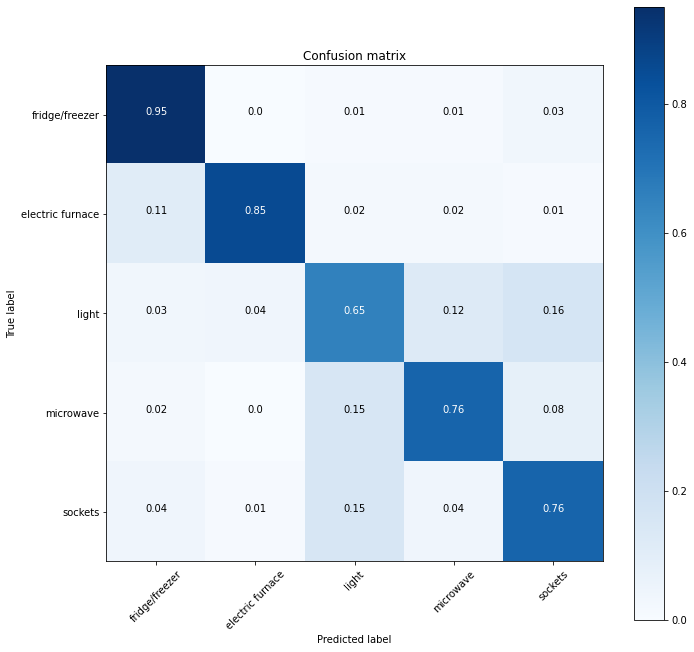

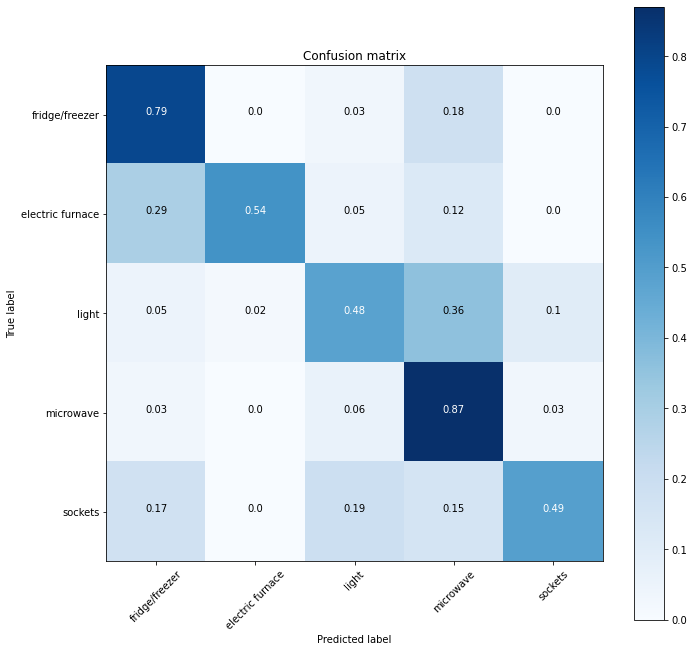

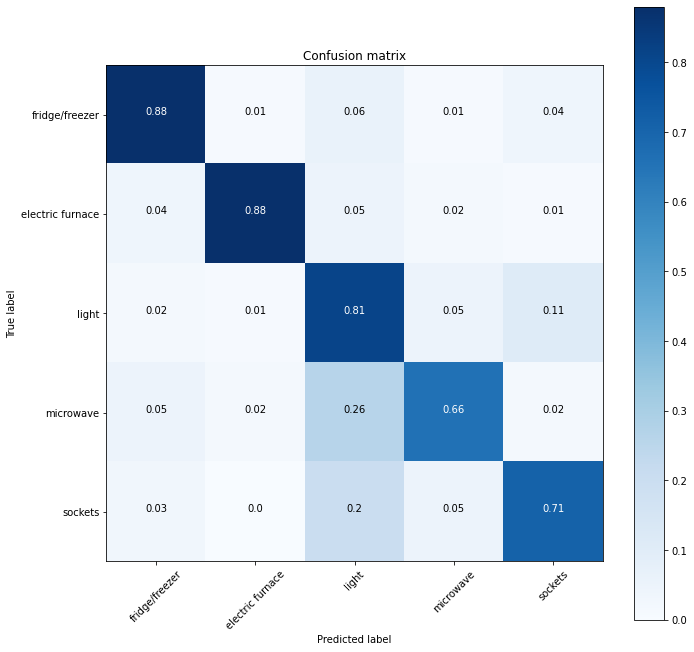

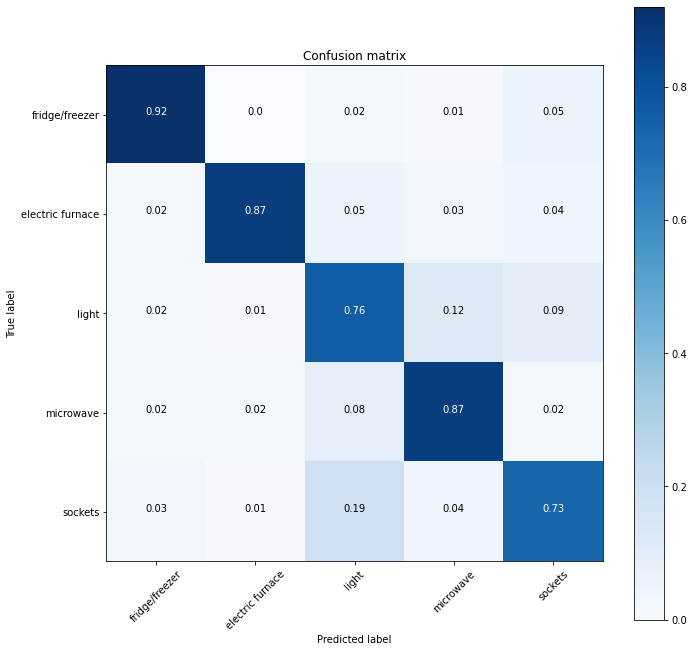

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()